In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 65 bytes


In [3]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

  0% 0.00/199k [00:00<?, ?B/s]
100% 199k/199k [00:00<00:00, 118MB/s]


In [4]:
import zipfile
import os

zip_file = "/content/house-prices-advanced-regression-techniques.zip"
extract_folder = "extracted_folder"

# Create a ZipFile object
with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    # Extract all the contents of zip file in the specified directory
    zip_ref.extractall(extract_folder)

print("Zip file extracted successfully!")

Zip file extracted successfully!


In [5]:
train_dir = '/content/extracted_folder/train.csv'
test_dir = '/content/extracted_folder/test.csv'

Training data shape: (1460, 81)
Test data shape: (1459, 80)
Mean Squared Error: 889378605.6574937
R² Score: 0.8840494417533191


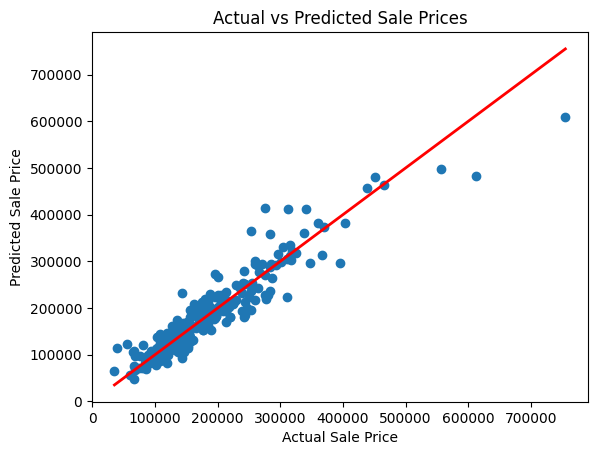

Predictions saved to 'house_price_predictions.csv'.


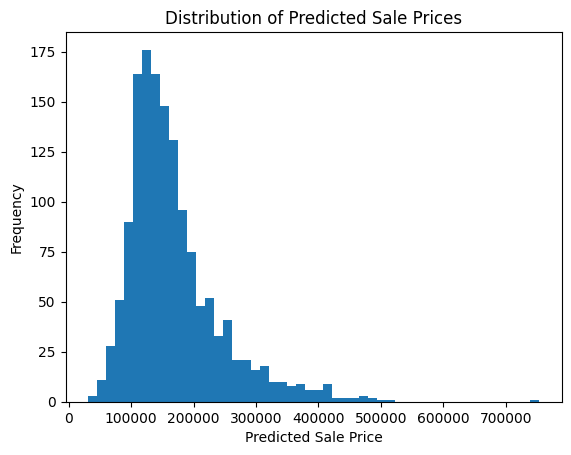

In [29]:
# Step 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Step 2: Load the datasets
train_data_path = '/content/extracted_folder/train.csv'
test_data_path = '/content/extracted_folder/test.csv'

try:
    train_data = pd.read_csv(train_data_path)
    test_data = pd.read_csv(test_data_path)
except Exception as e:
    print(f"Error reading the datasets: {e}")
    raise

# Verify the data is loaded correctly
print(f"Training data shape: {train_data.shape}")
print(f"Test data shape: {test_data.shape}")

# Preserve the 'Id' column in test data
test_ids = test_data['Id']

# Step 3: Preprocess the training data
numeric_cols = train_data.select_dtypes(include=[np.number]).columns.drop('SalePrice')
categorical_cols = train_data.select_dtypes(include=[object]).columns

# Impute missing values
numeric_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

train_data[numeric_cols] = numeric_imputer.fit_transform(train_data[numeric_cols])
train_data[categorical_cols] = categorical_imputer.fit_transform(train_data[categorical_cols])

# Convert categorical variables to numerical (dummy encoding)
train_data = pd.get_dummies(train_data, columns=categorical_cols, drop_first=True)

y_train = train_data['SalePrice']
X_train = train_data.drop(columns=['SalePrice'])

# Apply Polynomial Features to increase model complexity
poly = PolynomialFeatures(degree=2, include_bias=False)
X_train_poly = poly.fit_transform(X_train)

# Standardize the numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_poly)

# Step 4: Preprocess the test data similarly
test_data[numeric_cols] = numeric_imputer.transform(test_data[numeric_cols])
test_data[categorical_cols] = categorical_imputer.transform(test_data[categorical_cols])
test_data = pd.get_dummies(test_data, columns=categorical_cols, drop_first=True)
test_data = test_data.reindex(columns=X_train.columns, fill_value=0)

X_test_poly = poly.transform(test_data)
X_test_scaled = scaler.transform(X_test_poly)

# Step 5: Split the training data into training and validation sets
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Step 6: Train the model
model = LinearRegression()
model.fit(X_train_split, y_train_split)

# Step 7: Make predictions on the validation set
y_val_pred = model.predict(X_val_split)

# Step 8: Evaluate the model on the validation set
mse = mean_squared_error(y_val_split, y_val_pred)
r2 = r2_score(y_val_split, y_val_pred)
print(f"Mean Squared Error: {mse}")
print(f"R² Score: {r2}")

# Optional: Visualize the predictions vs actual values
plt.scatter(y_val_split, y_val_pred)
plt.xlabel("Actual Sale Price")
plt.ylabel("Predicted Sale Price")
plt.title("Actual vs Predicted Sale Prices")
plt.plot([y_val_split.min(), y_val_split.max()], [y_val_split.min(), y_val_split.max()], color='red', linewidth=2)
plt.show()

# Step 9: Make predictions on the test set
y_test_pred = model.predict(X_test_scaled)

# Step 10: Output predictions using original 'Id' column
predictions = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

predictions.to_csv('house_price_predictions.csv', index=False)
print("Predictions saved to 'house_price_predictions.csv'.")

# Optional: Visualize the distribution of predicted prices
plt.hist(y_test_pred, bins=50)
plt.xlabel("Predicted Sale Price")
plt.ylabel("Frequency")
plt.title("Distribution of Predicted Sale Prices")
plt.show()
